# MAD Dynamique <br>
### STAGE ANCHES <br>
Camille Urban <br>
22/03/2024

In [1]:
# classic shit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from statistics import mean
from scipy.signal import butter, filtfilt

#librosa
import librosa
import librosa.display

# traitement image
from skimage.io import imread
from skimage.transform import rotate
# from im_rotate import im_rotate
import os

import sounddevice as sd
from scipy.io.wavfile import write

from librosa.feature import rms
from librosa import pyin

from pyfilterbank import splweighting as splw           # https://siggigue.github.io/pyfilterbank/index.html


In [2]:
%matplotlib
%matplotlib

Using matplotlib backend: <object object at 0x000001D5C4A523B0>
Using matplotlib backend: TkAgg


## Paramètres du Banc

In [3]:
# SENSIBILITE CAPTEURS
S_mic_int =  0.0841  # Sensibilité du capteur de pression interne (mV/Pa)
Offset_mic_int = 51.2   # (mV) 
# G_micro_int = 10 V
S_force = 39.2 # mV/N
# Offset_force = 
# G_force = 10 V
# étalonnage de micro exterieur par source étalon 1kHz à 97dB

# FRQ ECHANTILLONNAGE
sr = 10000 
n_fft = 512 # env. 50ms
hop_length = n_fft // 4  # = 12.5ms (pas de décalage de la fenêtre)
p_ref = 2e-5
# 8 ou 12bits --> 16 serait mieux

largeur_bande = 100 # largeur de la bande frequentielle - freq_bande = 100  


In [4]:
dossier = 'mes_2024.04.19/'
nom_fichier = 'anche'
na = 2
data = pd.read_table(dossier + nom_fichier + f'{na}',  sep='\t', header=2).values
tps = data[:,0]
force = data[:,1]/S_force
p_int = (data[:,2])/S_mic_int
# print(type(p_int))
p_ext = data[:,3]
# vib = data[:,4]

nombre_anches = 5


# Traitement données

Démarche : <br>
    - Filtrages des signaux (pondération A ? autres ?) <br>
    - Normalisation des signaux <br>
    - Détection de la fréquence fondamentale par fft <br>
    - Filtrage fréquentiel du signal autour de la fréquence fondamentale avec une bande de largeur fréquentielle choisie <br>
    - Enveloppe spectrale par convolution avec fenêtre de Hann <br>
    - Seuillage sur l'enveloppe <br>
    - Troncature des signaux <br>
    

## Normalisation et pondération A

In [5]:
# NORMALISATION
 
def normalisation(signal):
    # normalized_signal = signal / np.mean(signal)
    normalized_signal = (signal / np.max(np.abs(signal))) * 0.95 # pour évtiter de froler les 1
    return normalized_signal


Ponderation A (http://siggigue.github.io/pyfilterbank/splweighting.html)

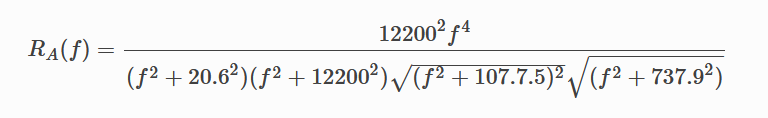
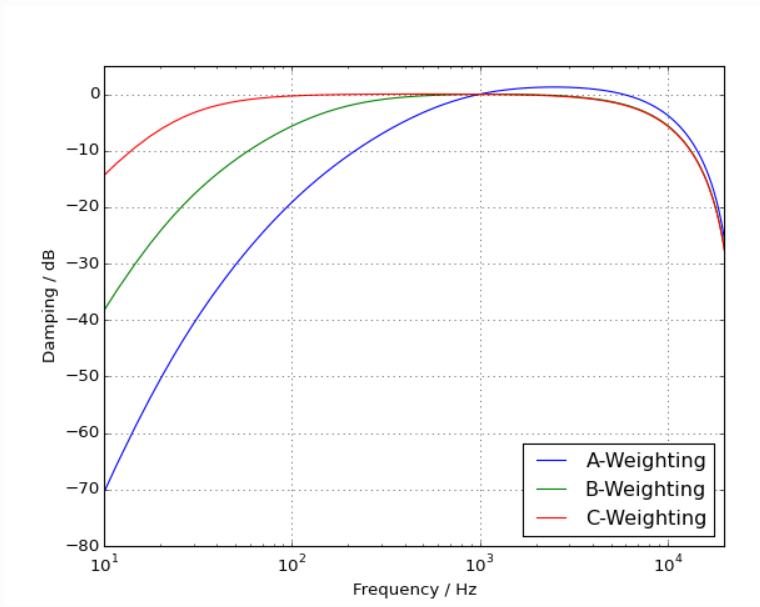


In [6]:
plt.close('all')
plot_fig = True
for na in range(2):
    dossier = 'mes_2024.04.19/'
    nom_fichier = 'anche'
    data = pd.read_table(dossier + nom_fichier + f'{na+1}',  sep='\t', header=2).values
    tps = data[:,0]
    force = data[:,1]/S_force
    p_int = (data[:,2])/S_mic_int
    weighted_signal = splw.weight_signal(p_int, sr, 'A')
    
    # print('RSB signal normalisé', signaltonoise(normalisation(p_int)))
    # print('RSB signal normalisé', signaltonoise(normalisation(weighted_signal)))
    
    
    if plot_fig :
        # fig, axs = plt.subplots(1, 1, figsize=(12, 6))
        # axs[0].plot(tps, p_int, label='Signal initial')
        # # axs[0].plot(tps, splw.weight_signal(p_int, sr, 'A'), label='Signal pondéré filtre A')
        # axs[0].set_xlabel('Temps (s)')
        # axs[0].set_ylabel('Amplitude')
        # axs[0].set_title('Filtrage sur signal brut')
        # axs[0].legend()
        # axs[0].grid()
                 
        # axs[1].plot(tps, normalisation(p_int), label='Signal normalisé')
        # axs[1].plot(tps, normalisation(splw.weight_signal(p_int, sr, 'A')), label='Signal pondéré A normalisé')
        # axs[1].plot(tps, splw.weight_signal(normalisation(p_int), sr, 'A'), label='Signal normalisé pondéré A')
        # axs[1].set_xlabel('Temps (s)')
        # axs[1].set_ylabel('Amplitude')
        # axs[1].set_title('siganux normalisés')
        # axs[1].legend()
        # axs[1].grid()
        
        plt.figure()
        plt.plot(tps, p_int, label='Signal initial')
        # pltig0].plot(tps, splw.weight_signal(p_int, sr, 'A'), label='Signal pondéré filtre A')
        plt.ylabel('Amplitude')
        plt.xlabel('Temps (s)')
        plt.grid('True')
        plt.title('Signal brut')
        plt.legend()
        


## **<span style="color:purple">Pour la suite on utilise le signal pondéré par le filtre A puis normalisé : </span>**



In [7]:
SIGNAL = normalisation(splw.weight_signal(p_int, sr, 'A'))

## Fréquence fondamentale 

In [8]:
# Trouver la fréquence fonda
#   ENTREE :
# signal traité (normalisé, etc.)
# frq echantillonnage
#   SORTIE : 
# frq fondamentale (scalaire en Hz)

def trouver_frequence_fondamentale(signal, sr) :  
    TF = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), d=1/sr)         # valeurs des frequences du spectre 
    indice_fonda = np.argmax(np.abs(TF[1:])) + 1        # indice de la frequence fondamentale (+1 pour éviter l'offset en 0)
    freq_fonda = np.abs(freqs[indice_fonda])            # fréquence fondamentale
    # print("Fréquence fondamentale :", freq_fonda)
    return freq_fonda


# Filtrer le signal autour de la fréquence fondamentale
#   ENTREE : 
# signal traité
# frq échantillonnage
# largeur de la bande passante autour de la fréquence fondamentale
#   SORTIE : 
# signal filtré autour de la fréquence fondamentale
#   ATTENTION : fait intervenir fct 'freq_fonda' 
 
def filtrage_frequentiel(signal, sr, largeur_bande):
    freq_fonda = trouver_frequence_fondamentale(signal, sr)
    
    # Definition de l'ordre du filtre
    ordre_filtre = 4  
    
    # Calcul des fréquences de coupure
    freq_coup_inf = freq_fonda - largeur_bande / 2
    freq_coup_sup = freq_fonda + largeur_bande / 2

    # fréquences de coupure en fréquences normalisées
    frequence_coupure_inf_norm = freq_coup_inf / (sr / 2)
    frequence_coupure_sup_norm = freq_coup_sup / (sr / 2)

    # Création du filtre passe-bande
    b, a = butter(ordre_filtre, [frequence_coupure_inf_norm, frequence_coupure_sup_norm], btype='band')

    # Filtrage du signal
    signal_filtre = filtfilt(b, a, signal)
    return signal_filtre



In [9]:
plot_fig = True
plt.close('all')
signal = SIGNAL
if plot_fig :
    plt.figure()
    # plt.plot(tps, signal, label='Signal pré-filtrage')
    plt.plot(tps, filtrage_frequentiel(signal, sr=sr, largeur_bande=largeur_bande), label='Signal filtré')
    plt.xlabel('Temps (s)')
    plt.ylabel('Amplitude normalisée')
    plt.title('Comparaison entre le signal initial et le signal filtré')
    plt.grid()
    plt.legend()
    plt.show()

## Enveloppe 

In [10]:
# Enveloppe par convolution avec fenêtre de Hann
#   ENTREE : 
# signal pré-traité
# taille de la fenêtre
#   SORTIE
# Enveloppe spectrale

def enveloppe_signal(signal, window_size): 
    # Calculer le nombre de segments
    num_segments = len(signal) // window_size
    
    # Initialiser l'enveloppe spectrale
    spectral_env = np.zeros(len(signal))
    
    # fenêtrage de Hann sur chaque segment et TF
    for i in range(num_segments):
        start_idx = i * window_size
        end_idx = (i + 1) * window_size
        segment = signal[start_idx:end_idx]
        
        # fenêtrage
        segment *= sp.signal.windows.hann(window_size)
        
        # TF et amplitude
        spectrum = np.fft.fft(segment)
        amplitude = np.abs(spectrum)
        
        spectral_env[start_idx:end_idx] = amplitude
    
    # Lissage par convolution
    spectral_env = np.convolve(spectral_env, np.ones(window_size) / window_size, mode='same')
    
    return spectral_env


In [11]:
plt.close('all')
# signal = SIGNAL
dossier = 'mes_2024.04.19/'
nom_fichier = 'anche'
na = 2
data = pd.read_table(dossier + nom_fichier + f'{na}',  sep='\t', header=2).values
tps = data[:,0]
force = data[:,1]/S_force
p_int = (data[:,2])/S_mic_int
signal = normalisation(p_int)

plot_fig = True
if plot_fig :
    plt.figure()
    plt.plot(tps, filtrage_frequentiel(signal, sr=sr, largeur_bande=largeur_bande), label='Signal normalisé filtré')
    plt.plot(tps, enveloppe_signal(filtrage_frequentiel(signal, sr=sr, largeur_bande=largeur_bande), window_size=n_fft), label='Enveloppe')
    plt.xlabel('Temps (s)')
    plt.ylabel('Amplitude normalisée')
    plt.grid()
    plt.title('Enveloppe du signal filtré autour de la fréquence fondamentale')
    plt.legend()
    plt.show()

## Seuillage

In [12]:
# Détermination du seuil de détéction paour chaque l'enveloppe spectrale du signal normalisé et filtré autour de f_0
# On prend le seuillage sur 100ms 
#   ENTREE
# enveloppe du signal pré-traité (pondéré, normalisé, filtré fréquentiellement autour de f0)
# fréquence d'échantillonnage
# facteur multiplicatif du std
#   SORTIE
# seuil (scalaire)


def seuillage(signal_env, sr, facteur_std):
       
    longueur_selection = int(0.1*sr) 
    selection = signal_env[:longueur_selection]
    e_type = np.std(selection)
    seuil = facteur_std*e_type  # seuil = 2*3*std idéalement
    # print(seuil)
    return seuil

signal_env = enveloppe_signal(filtrage_frequentiel(SIGNAL, sr, largeur_bande), window_size = n_fft)
seuil_detection = seuillage(signal_env, sr, facteur_std=20)
print(seuil_detection)

0.005344493113275605


## Troncature des signaux : 
pression d'alimentation croissante et décroissante

In [13]:
# Troncature du signal en deux signaux 
#   ENTREE :
# enveloppe du signal traité
# fréquence d'écahntillonngae
# facteur multiplicatif pour établir le seuillage (appelle la fonction seuillage)
#   SORTIE : 
# indices des section tronquées
#
def troncature(signal_env, sr, facteur_std) : 
    signal_env = signal_env / np.max(signal_env)

    # Seuil 
    seuil = seuillage(signal_env, sr, facteur_std)
    
    idx_tr = []
    seuil_depasse = True
    for i, valeur in enumerate(signal_env):
        if not seuil_depasse and valeur > seuil:
            seuil_depasse = True
            idx_tr.append(i)  # Ajouter le moment où le seuil est dépassé
        elif seuil_depasse and valeur <= seuil:
            seuil_depasse = False
            idx_tr.append(i) 
    idx_tr=idx_tr[1::]
    
    print(idx_tr)  
    return idx_tr, seuil

test = True
if test :
    signal_env = enveloppe_signal(filtrage_frequentiel(normalisation(splw.weight_signal(p_int, sr, 'A')), sr, largeur_bande), window_size = n_fft)
    idx_tr, seuil_detect = troncature(signal_env, sr, 20)

    plt.figure()
    plt.plot(tps, signal_env, label='Enveloppe')
    plt.hlines(seuil_detect, tps[0], tps[-1], color='yellow', label='')
    plt.xlabel('Temps')
    plt.ylabel('Amplitude')
    plt.title(f'Comparaison entre le signal initial et le signal filtré')
    plt.legend()
    
    
plot_env_spec = False
if plot_env_spec:
    plt.plot(tps, filtrage_frequentiel(normalisation(signal), sr=sr, largeur_bande=largeur_bande), label='Signal normalisé filtré')
    plt.plot(tps, enveloppe_signal(filtrage_frequentiel(normalisation(signal), sr=sr, largeur_bande=largeur_bande), window_size=n_fft), label='Enveloppe spectrale')
    plt.grid(True)
    plt.xlabel('Temps (s)')
    plt.ylabel('Energie')
    plt.title('Energie cumulative')
    plt.legend()

[19213, 36109, 45304, 63756]


# Application méthode de traitement

In [14]:
plt.close('all') 

plot_fig = True

facteur_multiplicatif_seuil=20 # facteur sdt pour le seuillage : a adapter

# Boucle sur N anches
for nbr_anche in range (2):
    #LOAD DATA
    data = pd.read_table(dossier + nom_fichier + f'{nbr_anche+1}', sep='\t', header=2).values
    tps = data[:,0]
    force = data[:,1]/S_force
    p_int = (data[:,2])/S_mic_int
    signal = p_int
    
    # calcul de l'enveloppe du signal filtré, normalisé et pondéré par un filtre A
    env_filtered_sig = enveloppe_signal(filtrage_frequentiel(normalisation(splw.weight_signal(p_int, sr, 'A')), sr, largeur_bande), window_size = n_fft)

    # TRONCATURE
    # Extraction de la valeur du seuil et les indices ou le signal coupe se seuil
    idx_troncature, seuil_detection = troncature(env_filtered_sig, sr=sr, facteur_std=facteur_multiplicatif_seuil) 
    # Toncature des signaux temps et pression en deux tronçons (pression d'alimentation croissante et décroissante)
    t_croiss = tps[idx_troncature[0]:idx_troncature[1]]
    t_decroiss = tps[idx_troncature[2]:idx_troncature[-1]]
    p_croiss = normalisation(p_int[idx_troncature[0]:idx_troncature[1]])
    p_decroiss =  normalisation(p_int[idx_troncature[2]:idx_troncature[-1]])
    # verification de la detection de seulement 4 indices
    if len(idx_troncature) != 4 : 
        print('erreur anche n°', nbr_anche)
        continue
    

    # Pression moyenne =  Pression d'alimention = P_mouth
    # réajustement pour centrer sur 0
    p_croiss -= mean(p_croiss)
    p_decroiss -= mean(p_decroiss)
    
        
    spectrogram_croiss = np.real((librosa.stft(y=p_croiss, n_fft=n_fft, hop_length=hop_length)))
    # récupération de la composante continue du spectrogramme et normalisation
    p_moy_bec_croiss = spectrogram_croiss[0,:]/(n_fft/2) 
    spectrogram_decroiss = np.real((librosa.stft(y=p_decroiss, n_fft=n_fft, hop_length=hop_length)))
    p_moy_bec_decroiss = spectrogram_decroiss[0,:]/(n_fft/2)
    
    # Pression Root Mean Square =  Pression acoustique 
    p_RMS_bec_croiss = []
    for i in range(spectrogram_croiss.shape[1]):
        fenetre_croiss = p_croiss[i * hop_length: i * hop_length + n_fft]-p_moy_bec_croiss[i]
        # temps_moy_bec.append(t[i * hop_length])
        p_RMS_bec_croiss.append(np.std(fenetre_croiss))
    p_RMS_bec_decroiss = []
    for i in range(spectrogram_decroiss.shape[1]):
        fenetre_de = p_decroiss[i * hop_length: i * hop_length + n_fft]-p_moy_bec_decroiss[i]
        # temps_moy_bec.append(t[i * hop_length])
        p_RMS_bec_decroiss.append(np.std(fenetre_de))
                                           
    # vecteur temps modifier pour avoir le découpage que P_moy et P_RMS    
    t_modif_croiss = np.arange(t_croiss[0], t_croiss[-1], (t_croiss[-1]-t_croiss[0])/len(p_moy_bec_croiss))
    t_modif_decroiss = np.arange(t_decroiss[0], t_decroiss[-1], (t_decroiss[-1]-t_decroiss[0])/len(p_moy_bec_decroiss))

    # Plot seuil
    if plot_fig :        
        fig, axs = plt.subplots(2, 2, figsize=(10, 8))
        
        # enveloppe spectral avec seuillage
        axs[0,0].plot(tps, env_filtered_sig, label='Enveloppe')
        axs[0,0].hlines(seuil_detect, tps[0], tps[-1], color='yellow', label='seuil')
        axs[0,0].grid(True)
        axs[0,0].set_xlabel('Temps')
        axs[0,0].set_ylabel('Amplitude normalisée')
        axs[0,0].set_title(f'Comparaison entre le signal initial et le signal filtré anche')
        axs[0,0].legend()
        

        # tronçon de signal pour pression d'alimentation croissante
        axs[1,0].plot(t_croiss, p_croiss, color='red')
        axs[1,0].plot(t_modif_croiss, p_moy_bec_croiss, color='darkred')
        axs[1,0].plot(t_modif_croiss, p_RMS_bec_croiss, color='lightcoral')
        axs[1,0].grid(True)
        axs[1,0].set_xlabel('Temps (s)')
        axs[1,0].set_ylabel('Amplitude noramlisée')
        axs[1,0].set_title('Pression d\'alimentation croissante')
        
        
        # tronçon de signal pour pression d'alimentation décroissante
        axs[1,1].plot(t_decroiss, p_decroiss, color='green')
        axs[1,1].plot(t_modif_decroiss, p_moy_bec_decroiss, color='darkgreen')
        axs[1,1].plot(t_modif_decroiss, p_RMS_bec_decroiss, color='lightgreen')
        axs[1,1].grid(True)
        axs[1,1].set_xlabel('Temps (s)')
        axs[1,1].set_ylabel('Amplitude normalisée')
        axs[1,1].set_title('Pression d\'alimentation décroissante')
        
        # P_ac selon P_m - hystérésis  
        axs[0,1].plot(p_moy_bec_croiss, p_RMS_bec_croiss, color='red', label='pression croissante') # problème de pression moyenne négative sur la première partie du plot
        axs[0,1].plot(p_moy_bec_decroiss, np.array(p_RMS_bec_decroiss), color='green', label='pression décroissante')
        axs[0,1].set_title(f'Pression RMS en fonction de la pression moyenne dans le bec')
        axs[0,1].grid(True)
        axs[0,1].set_xlabel('P_mouth - pression d\'alimentaion, ')
        axs[0,1].set_ylabel('p_ac - pression RMS bec')      
        
        fig.suptitle(f'Signaux tronqués - anche n°{nbr_anche+1}')
        plt.tight_layout(rect=[0.03, 0.03, 0.9, 0.97])
        


[17162, 25356, 44299, 61686]
[19213, 36109, 45304, 63756]


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [15]:
plt.close('all') 

plot_fig = True

facteur_multiplicatif_seuil=20 # facteur sdt pour le seuillage : a adapter

# Boucle sur N anches
for nbr_anche in range (1):
    #LOAD DATA
    data = pd.read_table(dossier + nom_fichier + f'{nbr_anche+1}', sep='\t', header=2).values
    tps = data[:,0]
    force = data[:,1]/S_force
    p_int = (data[:,2])/S_mic_int
    signal = p_int
    
    # calcul de l'enveloppe du signal filtré, normalisé et pondéré par un filtre A
    env_filtered_sig = enveloppe_signal(filtrage_frequentiel(normalisation(splw.weight_signal(p_int, sr, 'A')), sr, largeur_bande), window_size = n_fft)

    # TRONCATURE
    # Extraction de la valeur du seuil et les indices ou le signal coupe se seuil
    idx_troncature, seuil_detection = troncature(env_filtered_sig, sr=sr, facteur_std=facteur_multiplicatif_seuil) 
    # Toncature des signaux temps et pression en deux tronçons (pression d'alimentation croissante et décroissante)
    t_croiss = tps[idx_troncature[0]:idx_troncature[1]]
    t_decroiss = tps[idx_troncature[2]:idx_troncature[-1]]
  
    p_croiss = p_int[idx_troncature[0]:idx_troncature[1]]
    p_decroiss =  p_int[idx_troncature[2]:idx_troncature[-1]]
    
    p_croiss = normalisation(p_croiss)
    p_decroiss = normalisation(p_decroiss)
    
    # verification de la detection de seulement 4 indices
    if len(idx_troncature) != 4 : 
        print('erreur anche n°', nbr_anche)
        continue
    
    ####################################################
    # Enveloppe singal normalisé
    p_RMS_bec_croiss = enveloppe_signal(p_croiss, window_size = n_fft//4)   
    p_RMS_bec_decroiss = enveloppe_signal(p_decroiss, window_size = n_fft//4)
    
    # Pression moyenne
    spectrogram_croiss = np.real((librosa.stft(y=p_croiss, n_fft=n_fft, hop_length=hop_length)))
    p_moy_bec_croiss = spectrogram_croiss[0,:]/256
    p_moy_bec_croiss = np.arange(p_moy_bec_croiss[0], p_moy_bec_croiss[-1], (p_moy_bec_croiss[-1]-p_moy_bec_croiss[0])/len(p_RMS_bec_croiss))
    
    spectrogram_decroiss = np.real((librosa.stft(y=p_decroiss, n_fft=n_fft, hop_length=hop_length)))
    p_moy_bec_decroiss = spectrogram_decroiss[0,:]/256
    p_moy_bec_decroiss = np.arange(p_moy_bec_decroiss[0], p_moy_bec_decroiss[-1], (p_moy_bec_decroiss[-1]-p_moy_bec_decroiss[0])/len(p_RMS_bec_decroiss))
    print(p_moy_bec_croiss)
    
    t_modif_croiss = np.arange(t_croiss[0], t_croiss[-1], (t_croiss[-1]-t_croiss[0])/len(p_moy_bec_croiss))
    t_modif_decroiss = np.arange(t_decroiss[0], t_decroiss[-1], (t_decroiss[-1]-t_decroiss[0])/len(p_moy_bec_decroiss))

    
    if plot_fig :        
        fig, axs = plt.subplots(2, 2, figsize=(10, 8))
        
        # enveloppe spectral avec seuillage
        axs[0,0].plot(tps, env_filtered_sig, label='Enveloppe spectrale')
        axs[0,0].hlines(seuil_detect, tps[0], tps[-1], color='yellow', label='')
        axs[0,0].set_xlabel('Temps')
        axs[0,0].set_ylabel('Amplitude')
        axs[0,0].set_title(f'Comparaison entre le signal initial et le signal filtré')
        axs[0,0].legend()
        

        # tronçon de signal pour pression d'alimentation croissante
        axs[1,0].plot(t_croiss, p_croiss, color='red')
        axs[1,0].plot(t_modif_croiss, p_moy_bec_croiss, color='darkred')
        axs[1,0].plot(t_modif_croiss, p_RMS_bec_croiss, color='lightcoral')
        axs[1,0].grid(True)
        axs[1,0].set_xlabel('Temps (s)')
        axs[1,0].set_ylabel('Amplitude noramlisée')
        axs[1,0].set_title('pression d\'alimentation croissante')
        
        
        # tronçon de signal pour pression d'alimentation décroissante
        axs[1,1].plot(t_decroiss, p_decroiss, color='green')
        axs[1,1].plot(t_modif_decroiss, p_moy_bec_decroiss, color='darkgreen')
        axs[1,1].plot(t_modif_decroiss, p_RMS_bec_decroiss, color='lightgreen')
        axs[1,1].grid(True)
        axs[1,1].set_xlabel('Temps (s)')
        axs[1,1].set_ylabel('Amplitude normalisée')
        axs[1,1].set_title('pression d\'alimentation croissante')
        
        
        # P_ac selon P_m - hystérésis  
        axs[0,1].plot(p_moy_bec_croiss-np.min(p_moy_bec_croiss), p_RMS_bec_croiss, color='red', label='pression croissante') # problème de pression moyenne négative sur la première partie du plot
        # p_moy_bec_decroiss = np.arange(p_moy_bec_decroiss[0], p_moy_bec_decroiss[-1], (p_moy_bec_decroiss[-1]-p_moy_bec_decroiss[0])/len(p_moy_bec_croiss))  
        # p_RMS_bec_decroiss = np.arange(p_RMS_bec_decroiss[0], p_RMS_bec_decroiss[-1], (p_RMS_bec_decroiss[-1]-p_RMS_bec_decroiss[0])/len(p_RMS_bec_croiss))        
        axs[0,1].plot(np.flip(p_moy_bec_decroiss-np.min(p_moy_bec_decroiss)), p_RMS_bec_decroiss, color='green', label='pression décroissante')
        axs[0,1].set_title(f'Pression RMS en fonction de la pression moyenne dans le bec')
        axs[0,1].grid(True)
        axs[0,1].set_xlabel('P_mouth - pression d\'alimentaion, ')
        axs[0,1].set_ylabel('p_ac - pression RMS bec')      
        
        fig.suptitle(f'Signaux tronqués - anche n°{nbr_anche}')
        plt.tight_layout(rect=[0.03, 0.03, 0.9, 0.97])
        


[17162, 25356, 44299, 61686]
[-0.02208564 -0.02208554 -0.02208543 ... -0.02124533 -0.02124523
 -0.02124512]


# Ecouter les signaux

In [16]:
# RSB
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)
    # return 20*np.log10(abs(np.where(sd == 0, 0, m/sd)))

In [17]:
# ecoute et enregistrement des signaux en pression 
play_pression_bec = True
play_pression_ext  = False

for na in range (nombre_anches):
    if play_pression_bec:
        p_i = normalisation(p_int)
        audio_signal = np.int16(p_i * 32767)
        sd.play(audio_signal, sr)
        output_wav = dossier + f'pression_bec_anche{na}.wav'
        write(output_wav, sr, audio_signal)
        
    if play_pression_ext:
        p_e = normalisation(p_ext)
        audio_signal = np.int16(p_e * 32767)
        sd.play(audio_signal, sr)
        # output_wav = dossier + f'pression_ext_anche{na}.wav'
        # write(output_wav, sr, audio_signal)



In [18]:
dossier = 'mes_2024.04.19/'
nom_fichier = 'anche'
data = pd.read_table(dossier + nom_fichier + f'{na}',  sep='\t', header=2).values
tps = data[:,0]
force = data[:,1]/S_force
p_int = (data[:,2])/S_mic_int   
na =2

plt.close('all')
plt.figure() 
plt.title('Signal Brut')
plt.plot(tps, p_int)
print('RSB signal brut', signaltonoise(p_int))
sd.play(p_int, sr)   
p_int_audio = np.int16(p_int * 32767)
output_wav = dossier + f'sig_init{na}.wav'
write(output_wav, sr, p_int_audio)

plt.figure() 
plt.title('Signal Normalisé')
p_i = normalisation(p_int)
plt.plot(tps, p_i)
print('RSB signal normalisé', signaltonoise(p_i))
sd.play(p_i, sr)
p_i_audio = np.int16(p_i * 32767)
output_wav = dossier + f'sig_norma{na}.wav'
write(output_wav, sr, p_i_audio)

plt.figure() 
plt.title('Signal Préemphasis')
pre_emphasized = librosa.effects.preemphasis(p_i)
plt.plot(tps, p_i)
plt.plot(tps, pre_emphasized)
print('RSB signal Préemphasis', signaltonoise(pre_emphasized))
sd.play(pre_emphasized, sr)
pre_emphasized_audio = np.int16(pre_emphasized * 32767)
output_wav = dossier + f'sig_pre_emphasized{na}.wav'
write(output_wav, sr, pre_emphasized_audio)

plt.figure() 
plt.title('Signal pondéré A')
weighted_signal = splw.weight_signal(p_i, sr, 'A')
plt.plot(tps, p_i)
plt.plot(tps, weighted_signal)
print('RSB signal pondéré A', signaltonoise(weighted_signal))
sd.play(weighted_signal, sr)
weighted_signal_audio = np.int16(weighted_signal * 32767)
output_wav = dossier + f'sig_ponderation_A{na}.wav'
write(output_wav, sr, weighted_signal_audio)


RSB signal brut 0.03936009703670323
RSB signal normalisé 0.03936009703670324
RSB signal Préemphasis 0.008011028621669377
RSB signal pondéré A 1.222235253203358e-06


### Filtrage FIR 

In [19]:
plt.close('all')

dossier = 'mes_2024.04.19/'
nom_fichier = 'anche'
data = pd.read_table(dossier + nom_fichier + f'{1}',  sep='\t', header=2).values
tps = data[:,0]
force = data[:,1]/S_force
p_int = (data[:,2])/S_mic_int   
fc_low = 20
fc_high = 1800 


def filtre_FIR(signal, fc_low, fc_high):
    numtaps = 101  # Nombre de coefficients du filtre
    f_shan = sr/2
    low = fc_low/f_shan
    high = fc_high/f_shan
    coeffs = sp.signal.firwin(numtaps, [low, high], pass_zero=False)
    w, h = sp.signal.freqz(coeffs, worN=8000)
    plt.figure()
    plt.plot(f_shan * w / np.pi, np.abs(h), 'b')

    y = sp.signal.lfilter(coeffs, 1.0, signal)
    # plt.figure()
    # plt.plot(p_int)
    # plt.plot(y)
    return y
    
    

signal = filtre_FIR(p_int, fc_low, fc_high)
plt.figure() 
plt.title('Signal filtré passe bande')
plt.plot(tps, signal)
print('RSB signal "audio"', signaltonoise(signal))
sd.play(signal, sr)


RSB signal "audio" 0.03527675868520059


### Autre

In [20]:
from librosa.feature import rms
from librosa import pyin

plt.close('all')

# charger un tronçon de signal
dossier = 'mes_2024.04.19/'
nom_fichier = 'anche'
data = pd.read_table(dossier + nom_fichier + f'{4}', sep='\t', header=2).values
tps = data[:,0]
force = data[:,1]/S_force
p_int = (data[:,2])/S_mic_int
f=20
idx_tr, e_cum = troncature(signal=p_int, sr=sr, largeur_bande=100, window_size=n_fft, facteur_std=f)


t = tps[idx_tr[2]:idx_tr[-1]]
p = p_int[idx_tr[2]:idx_tr[-1]]


spectrogram = np.real((librosa.stft(y=p, n_fft=n_fft, hop_length=hop_length)))
p_moy_bec = spectrogram[0,:]/256

temps_moy_bec =[]
p_RMS_bec = []

for i in range(spectrogram.shape[1]):
    fenetre = p[i * hop_length: i * hop_length + n_fft]-p_moy_bec[i]
    temps_moy_bec.append(t[i * hop_length])
    p_RMS_bec.append(np.std(fenetre))


# p_RMS_bec = librosa.feature.rms(S=spectrogram, frame_length=n_fft, hop_length=hop_length).squeeze()


f_0_bec,_, _ = pyin(y=p,fmin=150, fmax=350, sr=sr, frame_length=n_fft, hop_length=hop_length)
print(f_0_bec.shape)
# CGS_bec = librosa.feature.spectral_centroid(y=p, sr=sr, S=spectrogram, n_fft=n_fft, hop_length=hop_length).squeeze()

plt.figure()
plt.plot(t, p)
plt.plot(temps_moy_bec, p_RMS_bec, 'r')

#####################################################################################################################################
# plt.figure()
# plt.title(f'Fréquence fondamentale en fonction de la pression moyenne dans le bec', fontsize=16)
# plt.scatter(p_moy_bec, f_0_bec)
# plt.grid(True)
# plt.xlabel('Pression moyenne dans le bec')
# plt.ylabel('Fréquence fondamentale')

# plt.figure()
# plt.title(f'Fréquence fondamentale en fonction de la pression moyenne dans le bec', fontsize=16)
# plt.plot(p_moy_bec, f_0_bec)
# plt.grid(True)
# plt.xlabel('Pression moyenne dans le bec')
# plt.ylabel('Fréquence fondamentale')


# plt.figure()
# plt.title(f'CGS en fonction de la pression moyenne dans le bec', fontsize=16)
# plt.scatter(p_moy_bec, CGS_bec)
# plt.grid(True)
# plt.xlabel('Pression moyenne dans le bec')
# plt.ylabel('CGS_bec')


# ######################################################################################################################################
# plt.figure()
# plt.title(f'Fréquence fondamentale en fonction de la pression RMS dans le bec', fontsize=16)
# plt.scatter(p_RMS_bec, f_0_bec)
# plt.grid(True)
# plt.xlabel('Pression RMS dans le bec')
# plt.ylabel('Fréquence fondamentale')
# plt.legend()

# plt.figure()
# plt.title(f'CGS en fonction de la pression RMS dans le bec', fontsize=16)
# plt.scatter(p_RMS_bec, CGS_bec)
# plt.grid(True)
# plt.xlabel('Pression RMS dans le bec')
# plt.ylabel('CGS_bec')
# plt.legend()


TypeError: troncature() got an unexpected keyword argument 'signal'

### Spectrogramme des signaux en pression (microphone interne et externe)

In [ ]:
# Entrée : signal, nombre d'échantillons, numéro de l'anche associée au signal
# Sortie : plot du spectrogramme
def plot_spectro(signal, n_fft, numero_anche):
    # Spectrogramme
    spectrogram = np.abs(librosa.stft(y=signal, n_fft=n_fft, hop_length=hop_length))
    # Mise en dB
    spectrogram_db = librosa.power_to_db(spectrogram**2, ref=p_ref**2)
    
    # Affichages des spectrogrammes
    plt.figure()
    plt.title(f'Sepctrogrammes \nAnche n° {numero_anche}', fontsize=16)
    
    img = librosa.display.specshow(spectrogram_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    cbar = plt.colorbar(img, format='%+2.0f dB')
    cbar.set_label('Amplitude (dB)')
    plt.title('Pression interne au bec')

    plt.tight_layout()
    plt.show()
    return spectrogram_db

plot_spec = True
if plot_spec:
    plt.close('all')      
    for i in range (nombre_anches):
        spectro_db = plot_spectro(normalisation(p_int), n_fft, i)


# Simulation

In [ ]:
# Définition de la fonction rectangulaire (rect)
def rect(t):
    return np.where(np.abs(t) < 0.5, 1, 0)


# Définition de la fonction à tracer
def solve(t, a, b, theta0, tau, T):
    y = a*t + b * np.sin(theta0 * t) * rect((t - tau)/T)
    P_m = a*t
    P_ac = b * np.sin(theta0 * t) * rect((t - tau)/T)
    energy_instantaneous = P_ac**2
    P_ac = np.cumsum(energy_instantaneous) 
    
    return P_m, P_ac, y


ex_sol =  True
if ex_sol:
    tps_deb, tps_fin, n_tps = 0, 20, 1000
    tps = np.linspace(tps_deb, tps_fin, n_tps)
    P_m, P_ac, y = solve(tps, 2, 5, 30*np.pi, 3, 4)
    # print(P_ac)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 6))
    ax1.plot(tps, y, label='$at + b\sin(\\theta_0 t) \cdot \mathrm{rect}(t - \\tau)$')
    ax1.set(xlabel='Temps (s)', ylabel='Amplitude')
    ax1.set_title('Simulation de la fonction $at + b\sin(\\theta_0 t) \cdot \mathrm{rect}(t - \\tau)$')
    # ax1.legend()
    ax1.grid()
    ax2.plot(P_m, P_ac, label='Pression acoustique en fonction de la pression dans la bouche')
    ax2.set(xlabel='P_m', ylabel='P_ac')
    ax2.set_title('Pression acoustique en fonction de la pression dans la bouche')
    # ax2.legend()
    ax2.grid()
    plt.show()

In [ ]:
from matplotlib.widgets import Button, Slider
plt.close('all')

# Création de la figure et des axes
fig, ax = plt.subplots(figsize=(10, 6))
plt.subplots_adjust(left=0.1, bottom=0.3, right=0.95, top=0.9)
ax.set_title('Simulation de la fonction \n$y(t) = at + b\sin(\\theta_0 t) \cdot \mathrm{rect}(t - \\tau)$')
ax.set(xlabel='Temps (s)', ylabel='Amplitude')
ax.grid()

# Initialisation des paramètres
a_init = 1
b_init = 2
omega0_init = np.round(2 * np.pi, 2)
tau_init = 1
T = 1

tps_deb, tps_fin, n_tps = 0, 20, 1000
t = np.linspace(tps_deb, tps_fin, n_tps)

# Tracé initial
P_m, P_ac, sol_y = solve(t, a_init, b_init, omega0_init, tau_init, T)
sol, = ax.plot(t, sol_y, lw=2)

# Positionnement des sliders
ax_a = fig.add_axes([0.1, 0.20, 0.6, 0.03], facecolor='lightgray')
ax_b = fig.add_axes([0.1, 0.15, 0.6, 0.03], facecolor='lightgray')
ax_omega0 = fig.add_axes([0.1, 0.1, 0.6, 0.03], facecolor='lightgray')
ax_tau = fig.add_axes([0.1, 0.05, 0.6, 0.03], facecolor='lightgray')

# Création des sliders
slider_a = Slider(ax_a, 'a', valmin=0.0, valmax=5.0, valinit=a_init)
slider_b = Slider(ax_b, 'b', 0.0, 5.0, valinit=b_init)
slider_theta0 = Slider(ax_omega0, '$\\theta_0$', 0.0, 100*np.pi, valinit=omega0_init)
slider_tau = Slider(ax_tau, '$\\tau$', 0.0, 5.0, valinit=tau_init)

# Positionnement et création du bouton de réinitialisation
resetax = plt.axes([0.8, 0.125, 0.1, 0.04])
button = Button(resetax, 'Reset', color='lightgray', hovercolor='0.975')

# Fonction de mise à jour des sliders
def update(val):
    new_t = np.linspace(tps_deb, slider_t.val, int(n_tps * (slider_t.val - tps_deb) / (tps_fin - tps_deb)))
    new_P_m, new_P_ac, new_y = solve(new_t, slider_a.val, slider_b.val, slider_theta0.val, slider_tau.val, slider_T.val)
    
    # Liaison des sliders à la fonction de mise à jour
    sol.set_ydata(new_y)
    sol.set_xdata(new_t)
    ax.set_ylim(1.08 * min(new_y), 1.08 * max(new_y))
    ax.set_xlim(tps_deb, 1.08 * max(new_t))
    
    fig.canvas.draw_idle()
    
slider_a.on_changed(update)
slider_b.on_changed(update)
slider_theta0.on_changed(update)
slider_tau.on_changed(update)

def reset(event):
    slider_a.reset()
    slider_b.reset()
    slider_theta0.reset()
    slider_tau.reset()

button.on_clicked(reset)

plt.show()


In [ ]:
from matplotlib.widgets import Button, Slider
plt.close('all')

# Création de la figure et des axes
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 6))
plt.subplots_adjust(left=0.1, bottom=0.3, right=0.95, top=0.9)
ax1.set_title('Simulation de la fonction \n$y(t) = at + b\sin(\\theta_0 t) \cdot \mathrm{rect}(\\frac{t - \\tau}{T})$')
ax1.set(xlabel='Temps (s)', ylabel='Amplitude')
ax1.grid()
ax2.set_title('Pression acoustique en fonction de \nla pression dans la bouche')
ax2.set(xlabel='$P_ac = at$', ylabel='$P_m = b\sin(\\theta_0 t) \cdot \mathrm{rect}(\\frac{t - \\tau}{T})$')
ax2.grid()



# Initialisation des paramètres
a_init = 2
b_init = 5
omega0_init = np.round(30 * np.pi, 2)
tau_init = 3
T_init = 4

tps_deb, tps_fin, n_tps = 0, 20, 1000
t = np.linspace(tps_deb, tps_fin, n_tps)

# Tracé initial
P_m, P_ac, sol_y = solve(t, a_init, b_init, omega0_init, tau_init, T_init)
sol, = ax1.plot(t, sol_y, lw=2)
pres, = ax2.plot(P_m, P_ac, lw=2 )


# Positionnement des sliders
time = fig.add_axes([0.1, 0.18, 0.6, 0.03], facecolor='lightgray')
ax_a = fig.add_axes([0.1, 0.15, 0.6, 0.03], facecolor='lightgray')
ax_b = fig.add_axes([0.1, 0.12, 0.6, 0.03], facecolor='lightgray')
ax_omega0 = fig.add_axes([0.1, 0.09, 0.6, 0.03], facecolor='lightgray')
ax_tau = fig.add_axes([0.1, 0.06, 0.6, 0.03], facecolor='lightgray')
ax_T = fig.add_axes([0.1, 0.03, 0.6, 0.03], facecolor='lightgray')

# Création des sliders
slider_t = Slider(time, 'temps (s)', valmin=tps_deb, valmax=tps_fin, valinit=6)
slider_a = Slider(ax_a, 'a', valmin=0.0, valmax=20.0, valinit=a_init)
slider_b = Slider(ax_b, 'b', 0.0, 20.0, valinit=b_init)
slider_theta0 = Slider(ax_omega0, '$\\theta_0$', 0.0, 100*np.pi, valinit=omega0_init)
slider_tau = Slider(ax_tau, '$\\tau$', 0.0, 20.0, valinit=tau_init)
slider_T = Slider(ax_T, 'T', 0.0, 20.0, valinit = T_init)

# Positionnement et création du bouton de réinitialisation
resetax = plt.axes([0.8, 0.125, 0.1, 0.04])
button = Button(resetax, 'Reset', color='lightgray', hovercolor='0.975')

# Fonction de mise à jour des sliders
def update(val):
    new_t = np.linspace(tps_deb, slider_t.val, int(n_tps * (slider_t.val - tps_deb) / (tps_fin - tps_deb)))
    new_P_m, new_P_ac, new_y = solve(new_t, slider_a.val, slider_b.val, slider_theta0.val, slider_tau.val, slider_T.val)
    new_P_m = new_t * new_P_m
    
    # Liaison des sliders à la fonction de mise à jour
    sol.set_ydata(new_y)
    sol.set_xdata(new_t)
    pres.set_ydata(new_P_ac)
    pres.set_xdata(new_P_m)
    
    ax1.set_xlim(tps_deb, 1.08 * max(new_t))
    ax1.set_ylim(1.08 * min(new_y), 1.08 * max(new_y))
    ax2.set_ylim(1.08 * min(new_P_ac), 1.08 * max(new_P_ac))
    ax2.set_xlim(1.08 * min(new_P_m), 1.08 * max(new_P_m))
    
    fig.canvas.draw_idle()

slider_t.on_changed(update)
slider_a.on_changed(update)
slider_b.on_changed(update)
slider_theta0.on_changed(update)
slider_tau.on_changed(update)
slider_T.on_changed(update)

def reset(event):
    slider_a.reset()
    slider_b.reset()
    slider_theta0.reset()
    slider_tau.reset()
    slider_T.reset()

button.on_clicked(reset)

plt.show()


SyntaxError: invalid syntax (968186766.py, line 29)

In [ ]:
plt.close('all') 

plot_fig = True

facteur_multiplicatif_seuil=20 # facteur sdt pour le seuillage : a adapter

# Boucle sur N anches
for nbr_anche in range (1):
    #LOAD DATA
    data = pd.read_table(dossier + nom_fichier + f'{nbr_anche+1}', sep='\t', header=2).values
    tps = data[:,0]
    force = data[:,1]/S_force
    p_int = (data[:,2])/S_mic_int
    signal = p_int
    
    # calcul de l'enveloppe du signal filtré, normalisé et pondéré par un filtre A
    env_filtered_sig = enveloppe_signal(filtrage_frequentiel(normalisation(splw.weight_signal(p_int, sr, 'A')), sr, largeur_bande), window_size = n_fft)

    # TRONCATURE
    # Extraction de la valeur du seuil et les indices ou le signal coupe se seuil
    idx_troncature, seuil_detection = troncature(env_filtered_sig, sr=sr, facteur_std=facteur_multiplicatif_seuil) 
    # Toncature des signaux temps et pression en deux tronçons (pression d'alimentation croissante et décroissante)
    t_croiss = tps[idx_troncature[0]:idx_troncature[1]]
    t_decroiss = tps[idx_troncature[2]:idx_troncature[-1]]
  
    p_croiss = p_int[idx_troncature[0]:idx_troncature[1]]
    p_decroiss =  p_int[idx_troncature[2]:idx_troncature[-1]]
    
    p_croiss = normalisation(p_croiss)
    p_decroiss = normalisation(p_decroiss)
    
    # verification de la detection de seulement 4 indices
    if len(idx_troncature) != 4 : 
        print('erreur anche n°', nbr_anche)
        continue
    
    ####################################################
    # Enveloppe singal normalisé
    p_RMS_bec_croiss = enveloppe_signal(p_croiss, window_size = n_fft//4)   
    p_RMS_bec_decroiss = enveloppe_signal(p_decroiss, window_size = n_fft//4)
    
    # Pression moyenne
    spectrogram_croiss = np.real((librosa.stft(y=p_croiss, n_fft=n_fft, hop_length=hop_length)))
    p_moy_bec_croiss = spectrogram_croiss[0,:]/256
    p_moy_bec_croiss = np.arange(p_moy_bec_croiss[0], p_moy_bec_croiss[-1], (p_moy_bec_croiss[-1]-p_moy_bec_croiss[0])/len(p_RMS_bec_croiss))
    
    spectrogram_decroiss = np.real((librosa.stft(y=p_decroiss, n_fft=n_fft, hop_length=hop_length)))
    p_moy_bec_decroiss = spectrogram_decroiss[0,:]/256
    p_moy_bec_decroiss = np.arange(p_moy_bec_decroiss[0], p_moy_bec_decroiss[-1], (p_moy_bec_decroiss[-1]-p_moy_bec_decroiss[0])/len(p_RMS_bec_decroiss))
    print(p_moy_bec_croiss)
    
    t_modif_croiss = np.arange(t_croiss[0], t_croiss[-1], (t_croiss[-1]-t_croiss[0])/len(p_moy_bec_croiss))
    t_modif_decroiss = np.arange(t_decroiss[0], t_decroiss[-1], (t_decroiss[-1]-t_decroiss[0])/len(p_moy_bec_decroiss))

    
    if plot_fig :        
        fig, axs = plt.subplots(2, 2, figsize=(10, 8))
        
        # enveloppe spectral avec seuillage
        axs[0,0].plot(tps, env_filtered_sig, label='Enveloppe spectrale')
        axs[0,0].hlines(seuil_detect, tps[0], tps[-1], color='yellow', label='')
        axs[0,0].set_xlabel('Temps')
        axs[0,0].set_ylabel('Amplitude')
        axs[0,0].set_title(f'Comparaison entre le signal initial et le signal filtré')
        axs[0,0].legend()
        

        # tronçon de signal pour pression d'alimentation croissante
        axs[1,0].plot(t_croiss, p_croiss, color='red')
        axs[1,0].plot(t_modif_croiss, p_moy_bec_croiss, color='darkred')
        axs[1,0].plot(t_modif_croiss, p_RMS_bec_croiss, color='lightcoral')
        axs[1,0].grid(True)
        axs[1,0].set_xlabel('Temps (s)')
        axs[1,0].set_ylabel('Amplitude noramlisée')
        axs[1,0].set_title('pression d\'alimentation croissante')
        
        
        # tronçon de signal pour pression d'alimentation décroissante
        axs[1,1].plot(t_decroiss, p_decroiss, color='green')
        axs[1,1].plot(t_modif_decroiss, p_moy_bec_decroiss, color='darkgreen')
        axs[1,1].plot(t_modif_decroiss, p_RMS_bec_decroiss, color='lightgreen')
        axs[1,1].grid(True)
        axs[1,1].set_xlabel('Temps (s)')
        axs[1,1].set_ylabel('Amplitude normalisée')
        axs[1,1].set_title('pression d\'alimentation croissante')
        
        
        # P_ac selon P_m - hystérésis  
        axs[0,1].plot(p_moy_bec_croiss-np.min(p_moy_bec_croiss), p_RMS_bec_croiss, color='red', label='pression croissante') # problème de pression moyenne négative sur la première partie du plot
        # p_moy_bec_decroiss = np.arange(p_moy_bec_decroiss[0], p_moy_bec_decroiss[-1], (p_moy_bec_decroiss[-1]-p_moy_bec_decroiss[0])/len(p_moy_bec_croiss))  
        # p_RMS_bec_decroiss = np.arange(p_RMS_bec_decroiss[0], p_RMS_bec_decroiss[-1], (p_RMS_bec_decroiss[-1]-p_RMS_bec_decroiss[0])/len(p_RMS_bec_croiss))        
        axs[0,1].plot(np.flip(p_moy_bec_decroiss-np.min(p_moy_bec_decroiss)), p_RMS_bec_decroiss, color='green', label='pression décroissante')
        axs[0,1].set_title(f'Pression RMS en fonction de la pression moyenne dans le bec')
        axs[0,1].grid(True)
        axs[0,1].set_xlabel('P_mouth - pression d\'alimentaion, ')
        axs[0,1].set_ylabel('p_ac - pression RMS bec')      
        
        fig.suptitle(f'Signaux tronqués - anche n°{nbr_anche}')
        plt.tight_layout(rect=[0.03, 0.03, 0.9, 0.97])
        


In [ ]:
# ESSAIS FOIREUX

from matplotlib.widgets import Button, Slider
plt.close('all')

# Création de la figure et des axes
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 6))
plt.subplots_adjust(left=0.1, bottom=0.3, right=0.95, top=0.9)
ax1.set_title('Simulation de la fonction \n$y(t) = at + b\sin(\\theta_0 t) \cdot \mathrm{rect}(\\frac{t - \\tau}{T})$')
ax1.set(xlabel='Temps (s)', ylabel='Amplitude')
ax1.grid()
ax2.set_title('Pression acoustique en fonction de \nla pression dans la bouche')
ax2.set(xlabel='$P_ac = at$', ylabel='$P_m = b\sin(\\theta_0 t) \cdot \mathrm{rect}(\\frac{t - \\tau}{T})$')
ax2.grid()



# Initialisation des paramètres
a_init = 2
b_init = 5
omega0_init = np.round(30 * np.pi, 2)
tau_init = 3
T_init = 4

tps_deb, tps_fin, n_tps = 0, 20, 1000
t = np.linspace(tps_deb, tps_fin, n_tps)

# Tracé initial
sol_y = solve(t, a_init, b_init, omega0_init, tau_init, T_init)
sol, = ax1.plot(t, sol_y, lw=2)
spectro = np.real((librosa.stft(y=sol_y, n_fft=n_fft, hop_length=hop_length)))
P_m = (spectro)[0,:]/256
P_ac = []
for i in range(spectro.shape[1]):
    fenetre = P_m[i * hop_length: i * hop_length + n_fft]-P_m[i]
    # temps_moy_bec.append(t[i * hop_length])
    P_ac.append(np.std(fenetre))
pres, = ax2.plot(P_m, P_ac, lw=2 )


# Positionnement des sliders
time = fig.add_axes([0.1, 0.18, 0.6, 0.03], facecolor='lightgray')
ax_a = fig.add_axes([0.1, 0.15, 0.6, 0.03], facecolor='lightgray')
ax_b = fig.add_axes([0.1, 0.12, 0.6, 0.03], facecolor='lightgray')
ax_omega0 = fig.add_axes([0.1, 0.09, 0.6, 0.03], facecolor='lightgray')
ax_tau = fig.add_axes([0.1, 0.06, 0.6, 0.03], facecolor='lightgray')
ax_T = fig.add_axes([0.1, 0.03, 0.6, 0.03], facecolor='lightgray')

# Création des sliders
slider_t = Slider(time, 'temps (s)', valmin=tps_deb, valmax=tps_fin, valinit=6)
slider_a = Slider(ax_a, 'a', valmin=0.0, valmax=20.0, valinit=a_init)
slider_b = Slider(ax_b, 'b', 0.0, 20.0, valinit=b_init)
slider_theta0 = Slider(ax_omega0, '$\\theta_0$', 0.0, 100*np.pi, valinit=omega0_init)
slider_tau = Slider(ax_tau, '$\\tau$', 0.0, 20.0, valinit=tau_init)
slider_T = Slider(ax_T, 'T', 0.0, 20.0, valinit = T_init)

# Positionnement et création du bouton de réinitialisation
resetax = plt.axes([0.8, 0.125, 0.1, 0.04])
button = Button(resetax, 'Reset', color='lightgray', hovercolor='0.975')

# Fonction de mise à jour des sliders
def update(val):
    new_t = np.linspace(tps_deb, slider_t.val, int(n_tps * (slider_t.val - tps_deb) / (tps_fin - tps_deb)))
    new_y = solve(new_t, slider_a.val, slider_b.val, slider_theta0.val, slider_tau.val, slider_T.val)
    new_spectro = np.real((librosa.stft(y=new_y, n_fft=n_fft, hop_length=hop_length)))
    new_P_m = (new_spectro)[0,:]/256
    new_P_ac = []
    for i in range(new_spectro.shape[1]):
        new_fenetre = new_P_m[i * hop_length: i * hop_length + n_fft]-new_P_m[i]
        # temps_moy_bec.append(t[i * hop_length])
        new_P_ac.append(np.std(new_fenetre))
    
    # Liaison des sliders à la fonction de mise à jour
    sol.set_ydata(new_y)
    sol.set_xdata(new_t)
    pres.set_ydata(new_P_ac)
    pres.set_xdata(new_P_m)
    
    ax1.set_xlim(tps_deb, 1.08 * max(new_t))
    ax1.set_ylim(1.08 * min(new_y), 1.08 * max(new_y))
    ax2.set_ylim(1.08 * min(new_P_ac), 1.08 * max(new_P_ac))
    ax2.set_xlim(1.08 * min(new_P_m), 1.08 * max(new_P_m))
    
    fig.canvas.draw_idle()

slider_t.on_changed(update)
slider_a.on_changed(update)
slider_b.on_changed(update)
slider_theta0.on_changed(update)
slider_tau.on_changed(update)
slider_T.on_changed(update)

def reset(event):
    slider_a.reset()
    slider_b.reset()
    slider_theta0.reset()
    slider_tau.reset()
    slider_T.reset()

button.on_clicked(reset)

plt.show()

ValueError: x and y must have same first dimension, but have shapes (1000,) and (3, 1000)